# Predicting Ratings from Review Text

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from glob import glob

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text))

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib
font = {'size' : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

FIG_SIZE = (15,6)
FIG_SIZE_SHORT = (15,3)

# Load Reviews

## All Reviews

In [11]:
time_marker('loading all reviews...')
reviews = pd.read_csv('./clean_data/_analysis/restaurant_reviews_top_countries.csv', index_col=0, parse_dates=['date'])
time_marker('done')

[21:44:12.255519] loading all reviews...


/Users/samgutentag/anaconda/envs/spring/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


[21:44:41.018561] done


In [36]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1676714 entries, 0 to 1676903
Data columns (total 13 columns):
business_id      1676714 non-null object
cool             1676714 non-null int64
date             1676714 non-null datetime64[ns]
funny            1676714 non-null int64
review_id        1676714 non-null object
stars            1676714 non-null int64
text             1676714 non-null object
useful           1676714 non-null int64
user_id          1676714 non-null object
review_length    1676714 non-null int64
state            1676714 non-null object
city             1676710 non-null object
country          1676714 non-null object
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 179.1+ MB


In [12]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,review_length,state,city,country
0,-QOz-2NrDkXjgKYEGBQZhA,0,2011-10-04,0,FERZQal0cYWKf8rVceC24w,3,thought we were coming in to dozo but instead ...,0,P2E31XC7SP4v_3hXC2o0Xw,815,ON,Markham,Canada
1,-QOz-2NrDkXjgKYEGBQZhA,0,2012-02-07,1,itCQYxlnjfnQPKQBU0K_dw,1,the atmosphere is great but saw the waitress p...,0,1P2GTkfjzlkJHZ4AQJYKbw,103,ON,Markham,Canada
2,-QOz-2NrDkXjgKYEGBQZhA,0,2012-10-04,0,T4JbEoTfq9O2f9Gzdd5Siw,3,had dinner here and it wasnt bad at all all yo...,1,GAf5JaZu2kNiFzrWjaWssw,244,ON,Markham,Canada
3,-QOz-2NrDkXjgKYEGBQZhA,0,2012-06-05,0,z7rXEvMWBZotEbxM6qABQQ,3,tried this place for the first time today asid...,0,eG09GDBWdQeWtSJdsP_pCw,1263,ON,Markham,Canada
4,-QOz-2NrDkXjgKYEGBQZhA,0,2012-11-07,0,tVkibM9wZgaxHi-TuxGrXA,2,in a word bland everything about this place is...,0,MVDtvZZgxSji8NxmCeg50w,451,ON,Markham,Canada


## Average Rating Per User

In [13]:
df = reviews.copy()

grp = df.groupby('user_id')
counts = grp.user_id.count()
means = grp.stars.mean()

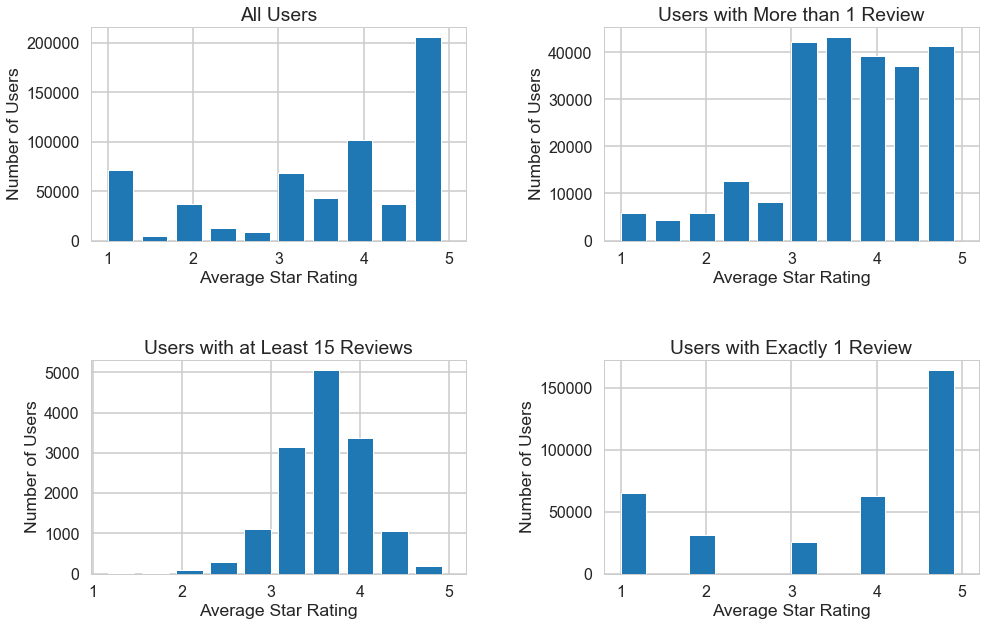

In [19]:
plt.rcParams['figure.figsize'] = (15,10)
fig, axes = plt.subplots(nrows=2, ncols=2)
width = 0.3
ax0, ax1, ax2, ax3 = axes.flatten()


ax0.hist(means, bins=10, edgecolor='w', lw=1, width=width)
ax0.set_title('All Users')
ax0.set_xlabel('Average Star Rating')
ax0.set_ylabel('Number of Users')

ax1.hist(means[counts > 1], bins=10, edgecolor='w', lw=1, width=width)
ax1.set_title('Users with More than 1 Review')
ax1.set_xlabel('Average Star Rating')
ax1.set_ylabel('Number of Users')

ax3.hist(means[counts == 1], bins=10, edgecolor='w', lw=1, width=width)
ax3.set_title('Users with Exactly 1 Review')
ax3.set_xlabel('Average Star Rating')
ax3.set_ylabel('Number of Users')

ax2.hist(means[counts >= 15], bins=10, edgecolor='w', lw=1, width=width)
ax2.set_title('Users with at Least 15 Reviews')
ax2.set_xlabel('Average Star Rating')
ax2.set_ylabel('Number of Users')

plt.tight_layout()
plt.show()
plt.close()


# Vector Space Model

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [141]:
def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.text)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.stars.values.astype(np.int)
    return X, y

In [226]:
# reviews_subset = reviews[:math.floor(reviews.shape[0]*0.1)].copy()
reviews_subset = reviews.copy()
reviews_subset.shape[0]

1676714

In [227]:
time_marker('vectorizing reviews...')
X, y = make_xy(reviews_subset)
time_marker('done!')

[00:27:46.998096] vectorizing reviews...
[00:32:30.330842] done!


## test and train split

In [228]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Multinomial Classifier

In [229]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()

In [230]:
time_marker('fitting classifier...')
nb_clf.fit(X_train, y_train)
time_marker('done!')

[01:34:44.594709] fitting classifier...
[01:34:49.595193] done!


In [231]:
# print the accuracy scores for both the training and the test sets
print("Accuracy on Training Set: {:2.4f}".format(100. * nb_clf.score(X_train, y_train)))
print("Accuracy on Testing Set:  {:2.4f}".format(100. * nb_clf.score(X_test, y_test)))

Accuracy on Training Set: 63.4038
Accuracy on Testing Set:  59.1126


In [232]:
y_pred = nb_clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.61      0.71      0.66     58829
          2       0.41      0.30      0.34     50136
          3       0.45      0.38      0.41     72693
          4       0.53      0.51      0.52    140874
          5       0.70      0.78      0.74    180483

avg / total       0.58      0.59      0.58    503015



# Tuning HyperParameters

In [233]:
reviews_df = reviews_subset.copy()

X, y = make_xy(reviews_df)

In [234]:
word_freq = pd.DataFrame(X.sum(axis=0).transpose())
word_freq.columns = ['freq']
word_freq.head(5)

,freq
0,90
1,51
2,8
3,2
4,3


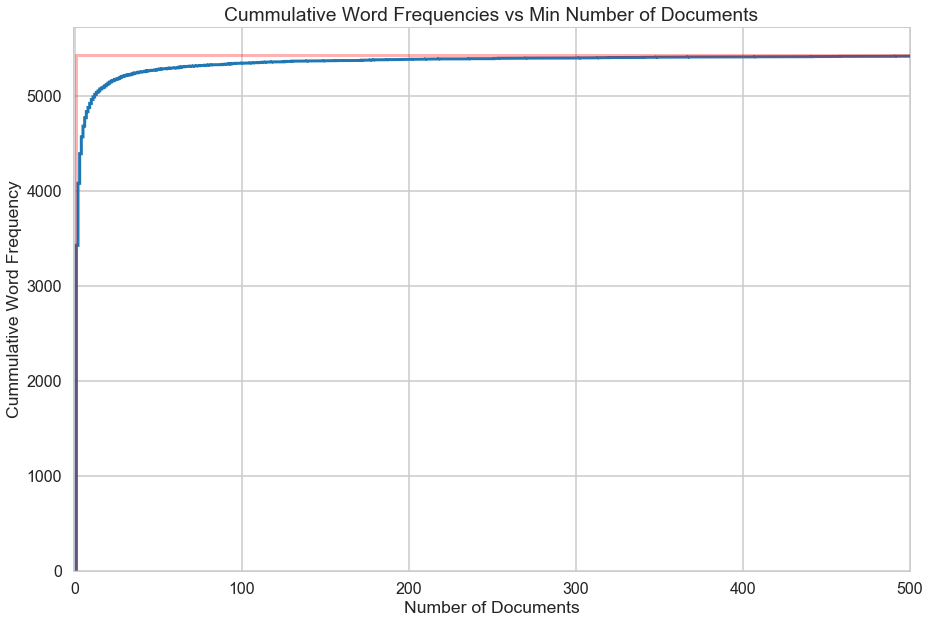

In [235]:
# plot cummulative histogram of word frequencies
plt.hist(word_freq.groupby('freq').size(), 
         bins = word_freq.groupby(['freq']).size().index[-1],
         histtype='step', cumulative=1, linewidth=3
        )

plt.hist(word_freq.groupby('freq').size(), 
         bins = 500,
         histtype='step', cumulative=1, linewidth=3, color ='r', alpha=0.3
        )

plt.xlim(-1, 500)
# plt.ylim(-1, 350)
plt.xlabel('Number of Documents')
plt.ylabel('Cummulative Word Frequency')
plt.title('Cummulative Word Frequencies vs Min Number of Documents')
plt.show()

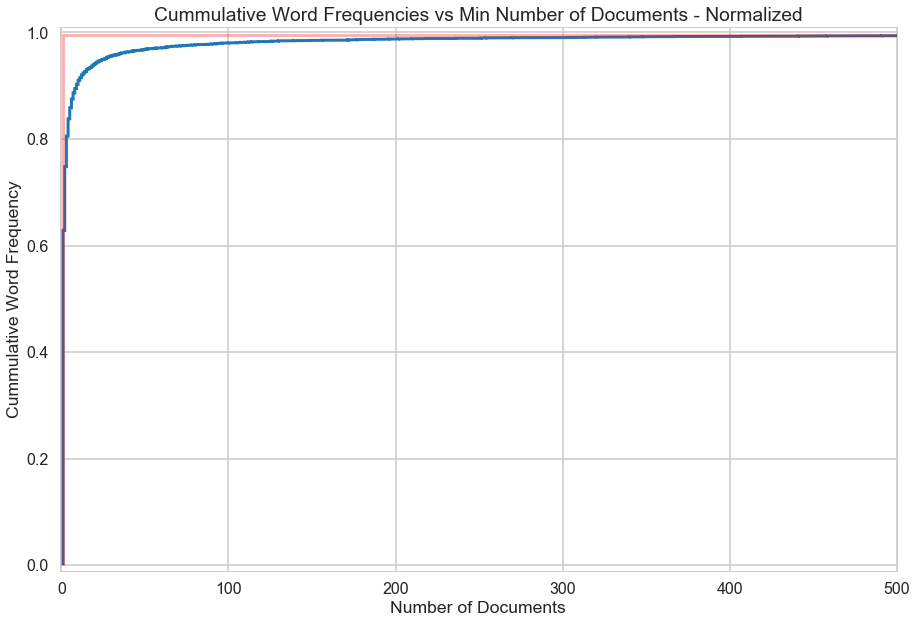

In [236]:
# plot cummulative histogram of word frequencies
plt.hist(word_freq.groupby('freq').size(), 
         bins = word_freq.groupby(['freq']).size().index[-1],
         histtype='step', cumulative=1, normed=1, linewidth=3
        )

plt.hist(word_freq.groupby('freq').size(), 
         bins = 500,
         histtype='step', cumulative=1, normed=1, linewidth=3, color ='r', alpha=0.3
        )

plt.xlim(-1, 500)
plt.ylim(-0.01, 1.01)
plt.xlabel('Number of Documents')
plt.ylabel('Cummulative Word Frequency')
plt.title('Cummulative Word Frequencies vs Min Number of Documents - Normalized')
plt.show()

# K Fold

In [237]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [238]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    
    star01 = y == 1
    star02 = y == 2
    star03 = y == 3
    star04 = y == 4
    star05 = y == 5
    
    score = prob[star01, 0].sum() + prob[star02, 1].sum() + prob[star03, 2].sum() + prob[star04, 3].sum() + prob[star05, 4].sum()
    return score
    

In [239]:
_, itest = train_test_split(range(reviews_subset.shape[0]), test_size=0.3, random_state=42)
mask = np.zeros(reviews_subset.shape[0], dtype=np.bool)
mask[itest] = True

In [249]:
time_marker('grid search started...')
#the grid of parameters to search over
alphas = [6500, 6750, 7000, 7250, 7500]
min_dfs = [0.125, 0.15, 0.175]#, 0.2, 0.225, 0.25]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = -np.inf
best_min_df = -np.inf
best_score = -np.inf

for alpha in alphas:
    for mindf in min_dfs:      
        vectorizer = CountVectorizer(min_df=mindf)       
        X, y = make_xy(reviews_subset, vectorizer)
        X_train = X[mask]
        y_train = y[mask]
        
        # instantiate classifier
        clf = MultinomialNB(alpha=alpha)
        
        # score the classifier
        score = cv_score(clf, X_train, y_train, log_likelihood)

        print('alpha:\t%0.1f\tmin_df:\t%0.4f\tscore:\t%0.4f\t' % (alpha, mindf, score))

        if score > best_score:
            best_score = score
            best_alpha = alpha
            best_min_df = mindf
    print("")
time_marker('done!')

[22:25:24.745162] grid search started...
alpha:	6500.0	min_df:	0.1250	score:	-137858.2871	
alpha:	6500.0	min_df:	0.1500	score:	-136854.0491	
alpha:	6500.0	min_df:	0.1750	score:	-141435.3941	

alpha:	6750.0	min_df:	0.1250	score:	-137825.7927	
alpha:	6750.0	min_df:	0.1500	score:	-136832.8974	
alpha:	6750.0	min_df:	0.1750	score:	-141358.3380	

alpha:	7000.0	min_df:	0.1250	score:	-137809.4192	
alpha:	7000.0	min_df:	0.1500	score:	-136823.2517	
alpha:	7000.0	min_df:	0.1750	score:	-141289.9250	

alpha:	7250.0	min_df:	0.1250	score:	-137809.4430	
alpha:	7250.0	min_df:	0.1500	score:	-136825.2835	
alpha:	7250.0	min_df:	0.1750	score:	-141230.1887	

alpha:	7500.0	min_df:	0.1250	score:	-137826.0956	
alpha:	7500.0	min_df:	0.1500	score:	-136839.1386	
alpha:	7500.0	min_df:	0.1750	score:	-141179.1550	

[23:58:16.143044] done!


In [250]:
print("Best alpha:  {}".format(best_alpha))
print("Best min_df: {}".format(best_min_df))
print("Best score: {}".format(best_score))

Best alpha:  7000
Best min_df: 0.15
Best score: -136823.2516982342


THIS IS BEST SETTINGS!

alpha = 7000
min_df = 0.15